In [1]:
import numpy as np
import matplotlib.pyplot as plt

# General Code

### Plotting

In [2]:
def plot_decision_boundary(X,W,t):
    #plot classes
    plt.scatter(X[0,:], X[1,:], c=t[0,:])
    
    #plot line
    x = [-5,5]
    y = [line(x[0],W), line(x[1],W)]
    plt.plot(x, y)
    
    plt.show()
    
def line(x,W):
    k = -(W.T[0]/W.T[1])
    m = -W.T[2]/W.T[1]
    return k*x+m

### Generating

In [26]:
def gen_binary(n = 100, bias = True):
    mA = [1.0, 0.5]
    mB = [-1.0, 0.0]
    sigmaA = 0.5
    sigmaB = 0.5
    
    classA1 = np.random.normal(mA[0],sigmaA,n) 
    classA2 = np.random.normal(mA[1],sigmaA,n)
    classA = np.vstack((classA1,classA2))
    labelA = np.ones((1,n))
    
    classB1 = np.random.normal(mB[0],sigmaB,n)
    classB2 = np.random.normal(mB[1],sigmaB,n)
    classB = np.vstack((classB1,classB2))
    labelB = -np.ones((1,n))
    
    data = np.hstack((classA,classB))
    labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,2*n])
    t = np.zeros([1,2*n])
    index = np.random.permutation(2*n)
    
    for i in index:
        X[:2,i] = data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = labels[0,index[i]]
    
    return X, t

def gen_W(X):
    W = np.random.normal(0, 1, (1, X.shape[0]))
    
    #bias
    if X[2,0] == 0:
        W.T[2] = 0
        
    return W

# Delta Rule

In [4]:
def delta(x, W, t, eta):
    inner = np.dot(W,x) - t
    return -eta * np.dot(inner, np.transpose(x))

def run_delta(x, W, t, n_epochs):
    n = 0.001
    for i in range(n_epochs):
        d = delta(x,W,t,n)
        W = W + d

# Main

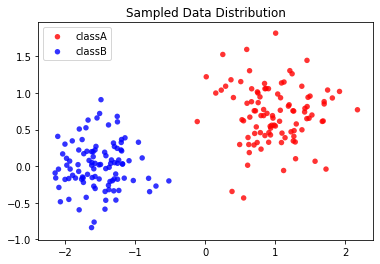

In [27]:
data = gen_binary()